# **MEDICAL INSURANCE CHARGE PREDICTION WITH GRADIENT BOOSTING**



# **IMPORTS, EDA, DATA ADJUSTMENT**

In [24]:
!pip install -q kagglehub optuna

In [25]:
import pandas as pd
import numpy as np
import kagglehub
import os

path = kagglehub.dataset_download("mirichoi0218/insurance")
df = pd.read_csv(os.path.join(path, "insurance.csv"))

In [26]:
print("Database first rows:")
print(df.head())

print("\nGeneral info:")
print(df.info())

print("\nStatistics:")
print(df.describe(include='all'))

print("\nNull values:")
print(df.isnull().sum())

print("\nDuplicate rows:")
print(df.duplicated().sum())

print("\nUnique values:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Database first rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Statistics:
                age   sex          bmi    

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.drop_duplicates()

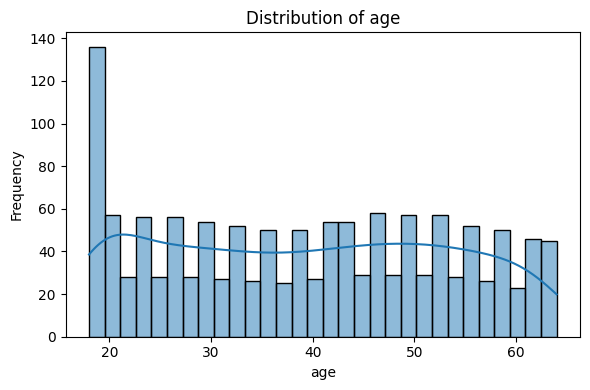

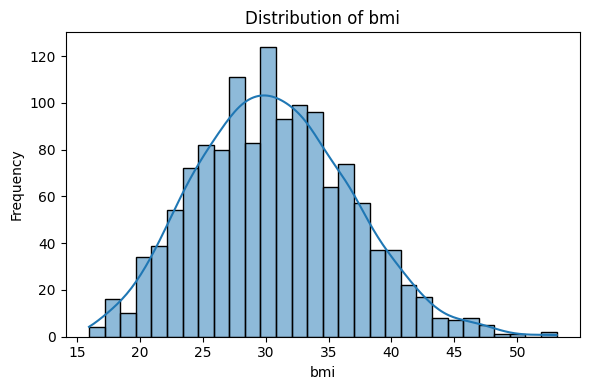

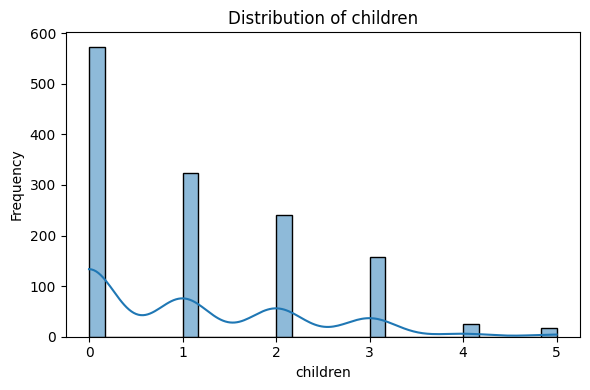

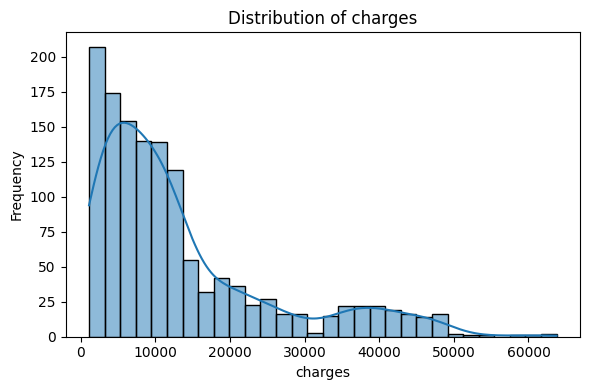

In [28]:
#Histogram of numerical variables
num_cols = ['age', 'bmi', 'children', 'charges']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

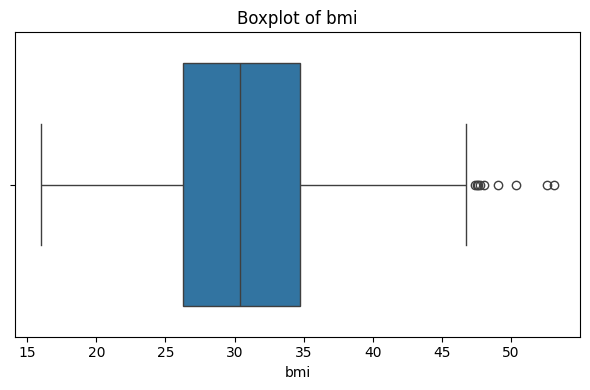

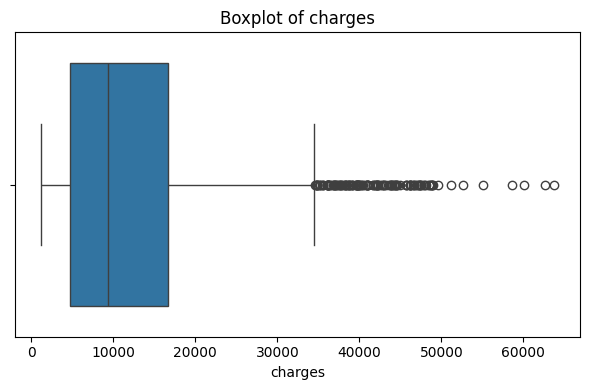

In [29]:
#Boxplots to detect outliers
for col in ['bmi', 'charges']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

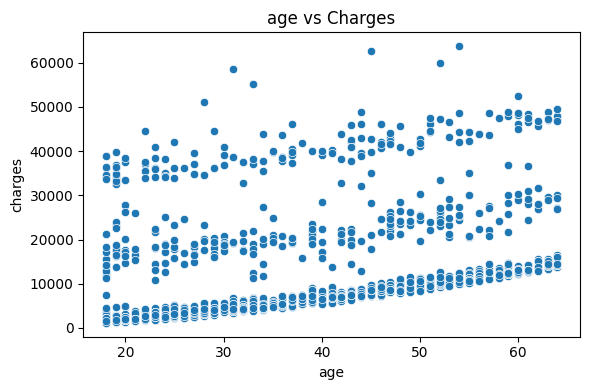

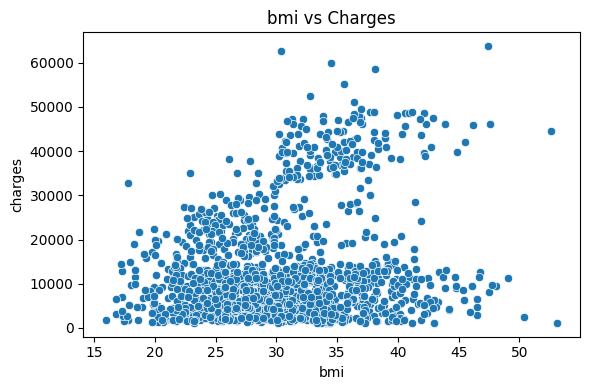

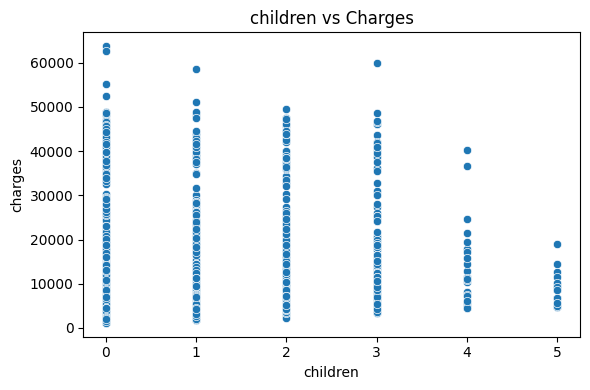

In [30]:
#Relationship between numerical variables and charges
for col in ['age', 'bmi', 'children']:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['charges'])
    plt.title(f'{col} vs Charges')
    plt.tight_layout()
    plt.show()

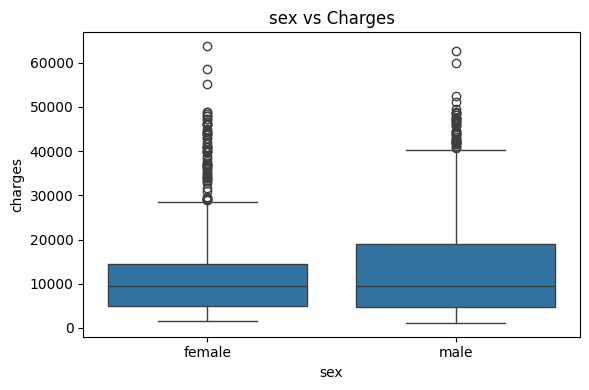

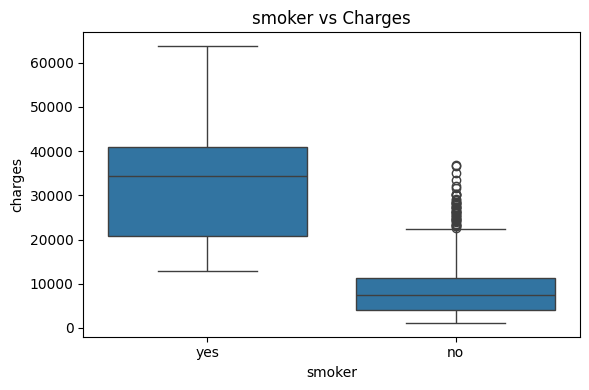

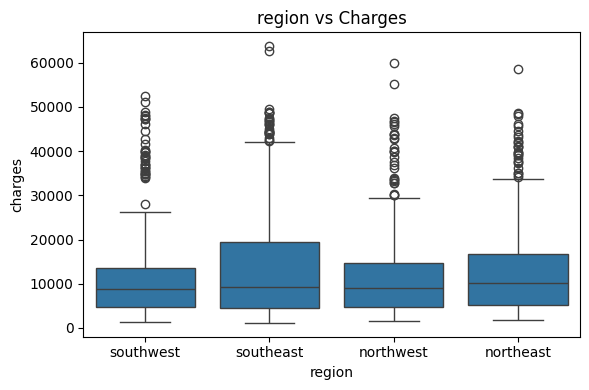

In [31]:
#Relationship between categorical variables and charges
cat_cols = ['sex', 'smoker', 'region']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], y=df['charges'])
    plt.title(f'{col} vs Charges')
    plt.tight_layout()
    plt.show()

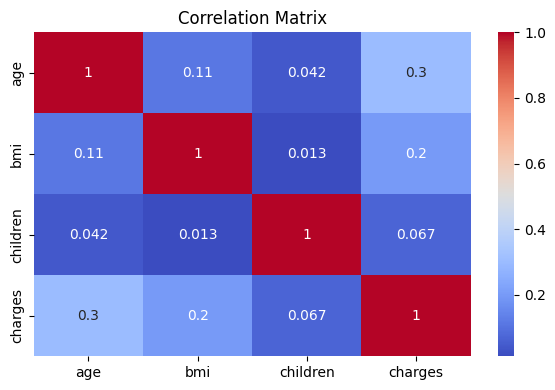

In [32]:
#Correlation between numerical variables
plt.figure(figsize=(6, 4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [33]:
from scipy.stats import shapiro

print("Normality test:")
stat, p = shapiro(df['charges'])
print(f'Statistic={stat:.4f}, p-value={p:.4f}')

Normality test:
Statistic=0.8148, p-value=0.0000


In [34]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

X = df[['age', 'bmi', 'children']]
X = sm.add_constant(X)
y = df['charges']

model = sm.OLS(y, X).fit()
bp_test = het_breuschpagan(model.resid, model.model.exog)
print("Heteroscedasticity test:")
print(bp_test)

Heteroscedasticity test:
(np.float64(134.314047200511), np.float64(6.357320042242207e-29), np.float64(49.62243731805152), np.float64(2.1055357922272045e-30))


*   Charges highly right skewed
*   No autocorrelation between features
*   Unbalanced age distribution for 20, potential outliers
*   Charges highly concentrated around 10K
*   Possible non linear interactions
*   Data does not follow a normal distribution (assimetric) (p < 0.05)
*   Data has heterocedasticy (error variance not constant) (p < 0.05)
*   Smoker, ibm, and age are strongest predictors




# **GRADIENT BOOSTING REGRESSOR**


*   Robust performance for small databases
*   Good for heterogenous data
*   Detects non linear interactions
*   Embedded regularization
*   Great for unbalanced datasets



In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import optuna

In [36]:
#Feature Engineering
X = df.drop(columns=["charges"]).copy()
y = np.log1p(df["charges"])

X['bmi_squared'] = X['bmi'] ** 2
X['bmi_age'] = X['bmi'] * X['age']
X['smoker_bmi'] = X['bmi'] * (X['smoker'] == 'yes').astype(int)
X['smoker_age'] = X['age'] * (X['smoker'] == 'yes').astype(int)
X['children_cat'] = pd.cut(X['children'], bins=[-1,0,1,2,5], labels=[0,1,2,3])
X.drop(columns=['children'], inplace=True)

In [37]:
#One-hot encoding
X = pd.get_dummies(X, drop_first=True)

#Feature selection
from sklearn.inspection import permutation_importance
model_fs = HistGradientBoostingRegressor(loss='squared_error', random_state=42)
model_fs.fit(X, y)
result = permutation_importance(model_fs, X, y, n_repeats=10, random_state=42,
                                scoring='neg_root_mean_squared_error')
importances = pd.Series(result.importances_mean, index=X.columns)
selected_features = importances[importances > 0.001].index.tolist()
X_selected = X[selected_features]
print("\nSelected features:")
print(selected_features)


Selected features:
['age', 'bmi', 'bmi_age', 'smoker_bmi', 'smoker_age', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest', 'children_cat_1', 'children_cat_2', 'children_cat_3']


In [38]:
#Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'loss': 'quantile', #Quantile loss
        'quantile': 0.5, #Median prediction
        'max_iter': trial.suggest_int('max_iter', 400, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.035),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.08, 0.12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 30),
        'early_stopping': True,
        'random_state': 42
    }

    model = HistGradientBoostingRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_selected, y, cv=cv, scoring='neg_root_mean_squared_error')

    return -scores.mean()

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [40]:
best_params = study.best_params
print("\nBest Params:")
print(best_params)


Best Params:
{'max_iter': 515, 'learning_rate': 0.029328459028477128, 'max_depth': 6, 'l2_regularization': 0.10535924630062563, 'min_samples_leaf': 27}


In [ ]:
#Model training
model_final = HistGradientBoostingRegressor(**best_params)
model_final.fit(X_selected, y)

In [42]:
#Predictions
y_pred = np.expm1(model_final.predict(X_selected))
y_true = df['charges']

In [43]:
#Evaluation
print("\nModel evaluation")
print(f"R²: {r2_score(y_true, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")


Model evaluation
R²: 0.9011
RMSE: 3806.7293
MAE: 1756.3601


*   Relatively small database limits rmse and mae performance
*   Still the model is reliable with excellent MAE and RMSE

# **MODEL PRECISION ANALYSIS**

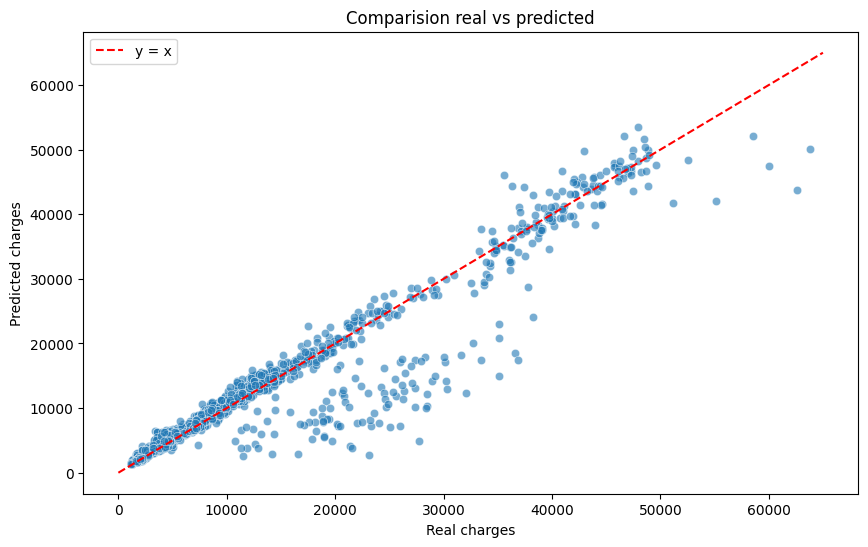

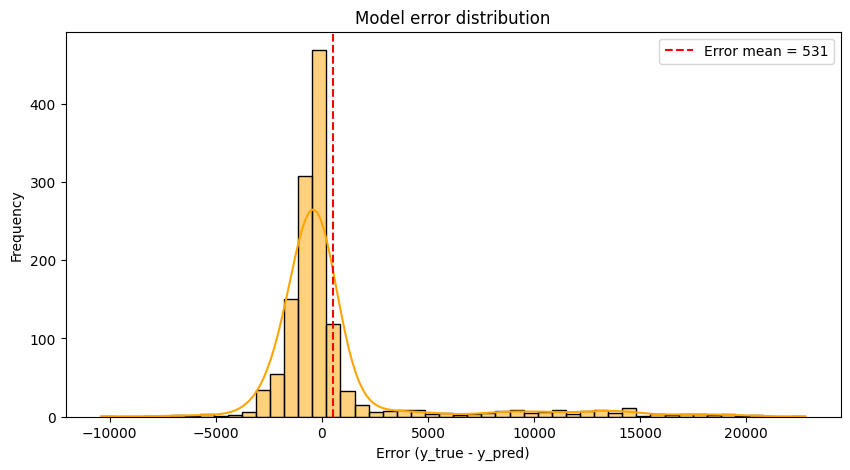

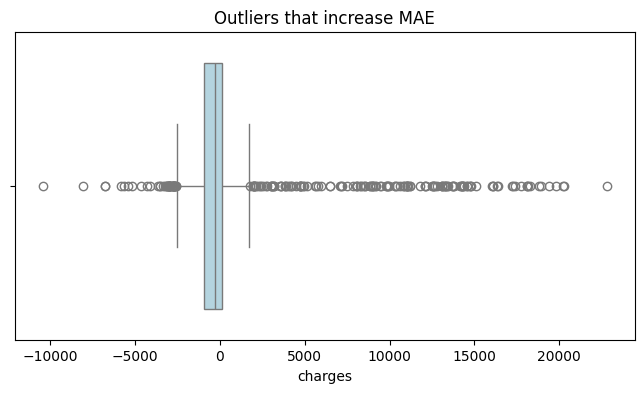

In [44]:
#Model errors
errors = y_true - y_pred

#Scatter plot: prediction vs real
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([0, 65000], [0, 65000], 'r--', label='y = x')
plt.xlabel("Real charges")
plt.ylabel("Predicted charges")
plt.title("Comparision real vs predicted")
plt.legend()
plt.show()

#Histogram of errors
plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True, color='orange')
plt.axvline(errors.mean(), color='red', linestyle='--', label=f'Error mean = {errors.mean():.0f}')
plt.xlabel("Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.title("Model error distribution")
plt.legend()
plt.show()

#Boxplot to hilight outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=errors, color='lightblue')
plt.title("Outliers that increase MAE")
plt.show()

In [50]:
#Real charges
charges = df['charges']

#Median
median_charge = charges.median()

#Errors if all predicted median
errors_median = charges - median_charge
mae_theoretical = np.mean(np.abs(errors_median))

#Model MAE
model_mae = mean_absolute_error(y_true, y_pred)

print(f"Charges median: {median_charge:.2f}")
print(f"Minimal theorical MAE possible: {mae_theoretical:.2f}")
print(f"Model MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"MAE improvement rate: {((mae_theoretical / model_mae) * 100):.2f}%")

Charges median: 9386.16
Minimal theorical MAE possible: 8351.49
Model MAE: 1756.36
MAE improvement rate: 475.50%
